<a href="https://colab.research.google.com/github/Bhargavi1504/Unsupervised-algorithms/blob/main/K_means_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unsupervised Learning

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

np.random.seed(42)
n=1000

#generating the base features
customer_ids=[f'CUST{10000+i}' for i in range(n)]
gender=np.random.choice(['male','female','other'],size=n,p=[0.48,0.48,0.04])
ages=np.random.randint(18,70,size=n)
locations=np.random.choice(['urban','sub-urban','rural'],size=n,p=[0.5,0.3,0.2])
signup_channels=np.random.choice(['app','web','referral','email'],size=n,p=[0.4,0.3,0.2,0.1])

#session and purchase behaviour
total_visits = np.random.poisson(lam=20,size=n)
time_on_site = np.random.normal(loc=300,scale=100,size=n).astype(int)
avg_session_length = np.random.normal(loc=15,scale=5,size=n).clip(5,60)
total_purchases =np.random.poisson(lam=5,size=n)

#spending product preference
total_spend=(total_purchases * np.random.normal(50,20,size=n)).clip(10,3000)
favorite_category = np.random.choice(['Clothing', 'Electronics', 'Home', 'Books', 'Beauty', 'Sports'], size=n)


# 4. Returns, Coupons, Ratings
returned_items = np.random.binomial(total_purchases, p=0.1)
cart_abandon_rate = np.random.beta(2, 5, size=n).round(2)
used_coupons = np.random.poisson(3, size=n)
ratings_given = np.random.poisson(5, size=n)


# 5. Recency
last_purchase_days_ago = np.random.randint(0, 365, size=n)

# Assemble into DataFrame
d = pd.DataFrame({
    'CustomerID': customer_ids,
    'Gender': gender,
    'Age': ages,
    'Location': locations,
    'SignupChannel': signup_channels,
    'TotalVisits': total_visits,
    'TimeOnSite(min)': time_on_site,
    'AvgSessionLength(min)': avg_session_length,
    'TotalPurchases': total_purchases,
    'TotalSpend': total_spend.round(2),
    'FavoriteCategory': favorite_category,
    'ReturnedItems': returned_items,
    'CartAbandonRate': cart_abandon_rate,
    'UsedCoupons': used_coupons,
    'RatingsGiven': ratings_given,
    'LastPurchaseDate': last_purchase_days_ago
})

#injecting missing values
for col in ['Gender','TimeOnSite(min)','FavoriteCategory']:
  d.loc[d.sample(frac=0.02).index,col]=np.nan

#duplicate rows
d=pd.concat([d,d.sample(frac=0.02)],ignore_index=True)

#inject outliers
outlier_indices=np.random.choice(d.index,size=10,replace=False)
d.loc[outlier_indices,'TotalSpend'] *= 5
d.loc[outlier_indices,'ReturnedItems'] += 20

#display sample
print("✅ Dataset created with shape:", d.shape)
d.head()

✅ Dataset created with shape: (1020, 16)


,CustomerID,Gender,Age,Location,SignupChannel,TotalVisits,TimeOnSite(min),AvgSessionLength(min),TotalPurchases,TotalSpend,FavoriteCategory,ReturnedItems,CartAbandonRate,UsedCoupons,RatingsGiven,LastPurchaseDate
0,CUST10000,male,64,urban,referral,21,375.0,20.516088,5,334.40,Electronics,0,0.19,6,7,288
1,CUST10001,female,29,sub-urban,app,18,108.0,22.209712,4,177.31,Books,2,0.41,6,10,247
2,CUST10002,female,33,rural,referral,18,365.0,16.094820,5,381.63,Electronics,1,0.20,2,5,49
3,CUST10003,female,41,sub-urban,app,21,219.0,10.790892,5,10.00,Books,1,0.28,2,5,358
4,CUST10004,male,36,sub-urban,app,24,330.0,5.000000,4,102.18,Electronics,0,0.16,2,5,282


Step 1: Data Overview (nulls, types, duplicates, distributions)

In [ ]:
print('shape:',d.shape)
print('data types:',d.dtypes)

#nulls
print('Missing values:',d.isnull().sum())

#duplicates
print('duplicates:',d.duplicated().sum())

#stats summary
print('statistical summary:',d.describe())

#value counts for cat cols
for i in ['Gender','Location','SignupChannel','FavoriteCategory']:
  print(f'value counts for {i}',d[i].value_counts(dropna=False))

shape: (1020, 16)
data types: CustomerID                object
Gender                    object
Age                        int64
Location                  object
SignupChannel             object
TotalVisits                int64
TimeOnSite(min)          float64
AvgSessionLength(min)    float64
TotalPurchases             int64
TotalSpend               float64
FavoriteCategory          object
ReturnedItems              int64
CartAbandonRate          float64
UsedCoupons                int64
RatingsGiven               int64
LastPurchaseDate           int64
dtype: object
Missing values: CustomerID                0
Gender                   20
Age                       0
Location                  0
SignupChannel             0
TotalVisits               0
TimeOnSite(min)          20
AvgSessionLength(min)     0
TotalPurchases            0
TotalSpend                0
FavoriteCategory         20
ReturnedItems             0
CartAbandonRate           0
UsedCoupons               0
RatingsGiven        

✅ Missing values after imputation:
 Gender              0
FavoriteCategory    0
TimeOnSite(min)     0
dtype: int64
✅ Shape after removing duplicates: (1000, 16)
🔁 Remaining duplicate rows: 0


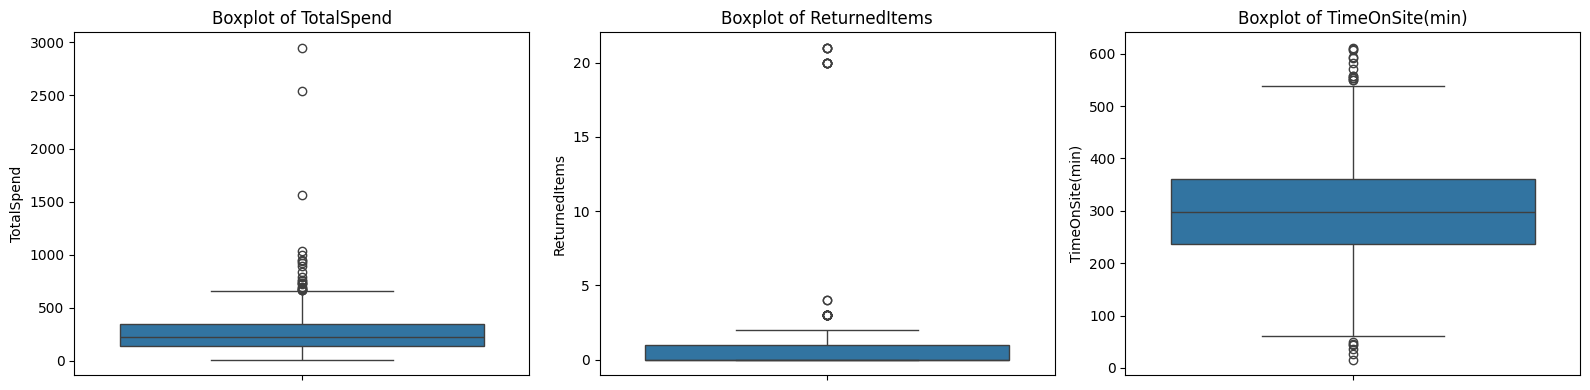


📌 TotalSpend: 22 outliers
   - Lower Bound: -182.60, Upper Bound: 660.23

📌 ReturnedItems: 25 outliers
   - Lower Bound: -1.50, Upper Bound: 2.50

📌 TimeOnSite(min): 19 outliers
   - Lower Bound: 51.00, Upper Bound: 547.00


In [ ]:
# Code to Handle Missing Values:
from sklearn.impute import SimpleImputer
cat_c=['Gender','FavoriteCategory']
num_c=['TimeOnSite(min)']

d[cat_c]=d[cat_c].fillna('Missing')

num_imputer=SimpleImputer(strategy='median')
d[num_c]=num_imputer.fit_transform(d[num_c])

# Sanity check
print("✅ Missing values after imputation:\n", d[cat_c + num_c].isnull().sum())


#Code to Remove Duplicates:
d = d.drop_duplicates()

# Confirm
print("✅ Shape after removing duplicates:", d.shape)
print("🔁 Remaining duplicate rows:", d.duplicated().sum())

#outliers
#A. Visual Outlier Detection (Boxplots)
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns to inspect
cols_to_check = ['TotalSpend', 'ReturnedItems', 'TimeOnSite(min)']

plt.figure(figsize=(16, 4))
for i, col in enumerate(cols_to_check):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=d[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#B. Numeric Outlier Detection with IQR
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for all three
for col in cols_to_check:
    outliers, lb, ub = detect_outliers_iqr(d, col)
    print(f"\n📌 {col}: {len(outliers)} outliers")
    print(f"   - Lower Bound: {lb:.2f}, Upper Bound: {ub:.2f}")


In [ ]:
# Function to cap outliers using IQR
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                          np.where(df[column] > upper_bound, upper_bound, df[column]))

# Apply to selected columns
for col in ['TotalSpend', 'ReturnedItems', 'TimeOnSite(min)']:
    cap_outliers_iqr(d, col)

# Check again
print("✅ Outliers capped.")


✅ Outliers capped.


In [ ]:
#encoding

from sklearn.preprocessing import LabelEncoder

# Copy the original raw dataset to a new one
d_encoded = d.copy()

# Initialize encoders
enc_gender = LabelEncoder()
enc_location = LabelEncoder()
enc_signup = LabelEncoder()
enc_category = LabelEncoder()

# ✅ Fit on ORIGINAL string data, and transform
d_encoded['Gender'] = enc_gender.fit_transform(d['Gender'])
d_encoded['Location'] = enc_location.fit_transform(d['Location'])
d_encoded['SignupChannel'] = enc_signup.fit_transform(d['SignupChannel'])
d_encoded['FavoriteCategory'] = enc_category.fit_transform(d['FavoriteCategory'])

# Optional: check classes to verify
print("✅ Gender classes:", enc_gender.classes_)
print("✅ location classes:", enc_location.classes_)
print("✅ SignupChannel classes:", enc_signup.classes_)
print("✅ FavoriteCategory classes:", enc_category.classes_)







#scaling
from sklearn.preprocessing import StandardScaler

# Drop identifier column
d_final = d_encoded.drop(columns=['CustomerID'])

# Store CustomerID separately for future use
customer_ids = d_encoded['CustomerID']

# Apply StandardScaler
scaler = StandardScaler()
d_scaled=pd.DataFrame(scaler.fit_transform(d_final),columns=d_final.columns)

# Attach back customer IDs for tracking
d_scaled['CustomerID'] = customer_ids.values

print("✅ Final scaled dataset shape:", d_scaled.shape)
d_scaled.head()


✅ Gender classes: ['Missing' 'female' 'male' 'other']
✅ location classes: ['rural' 'sub-urban' 'urban']
✅ SignupChannel classes: ['app' 'email' 'referral' 'web']
✅ FavoriteCategory classes: ['Beauty' 'Books' 'Clothing' 'Electronics' 'Home' 'Missing' 'Sports']
✅ Final scaled dataset shape: (1000, 16)


,Gender,Age,Location,SignupChannel,TotalVisits,TimeOnSite(min),AvgSessionLength(min),TotalPurchases,TotalSpend,FavoriteCategory,ReturnedItems,CartAbandonRate,UsedCoupons,RatingsGiven,LastPurchaseDate,CustomerID
0,0.775205,1.393733,0.907060,0.485383,0.222202,0.792358,1.128548,0.013114,0.537945,0.164331,-0.775894,-0.588167,1.663571,0.944164,1.063550,CUST10000
1,-0.884763,-0.969556,-0.381377,-1.080369,-0.447081,-1.966132,1.466123,-0.424026,-0.482528,-0.846935,2.127357,0.832994,1.663571,2.307249,0.664918,CUST10001
2,-0.884763,-0.699466,-1.669815,0.485383,-0.447081,0.689044,0.247296,0.013114,0.844756,0.164331,0.675732,-0.523568,-0.608291,0.035440,-1.260182,CUST10002
3,-0.884763,-0.159286,-0.381377,-1.080369,0.222202,-0.819344,-0.809889,0.013114,-1.569391,-0.846935,0.675732,-0.006783,-0.608291,0.035440,1.744141,CUST10003
4,0.775205,-0.496898,-0.381377,-1.080369,0.891485,0.327444,-1.964136,-0.424026,-0.970580,0.164331,-0.775894,-0.781961,-0.608291,0.035440,1.005213,CUST10004


KMEANS clustering


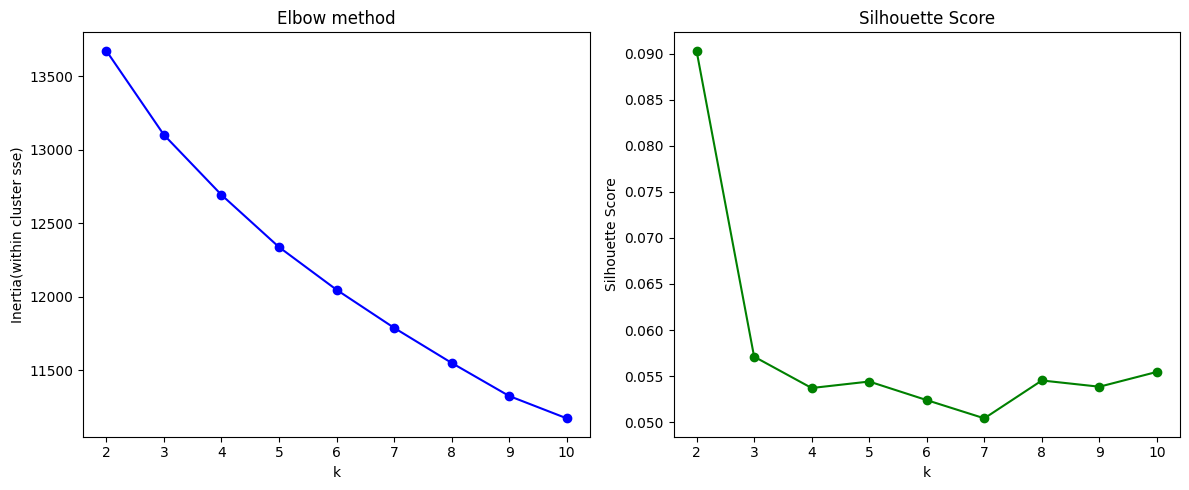

In [ ]:
#applying elbow method to determine optimal k
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

X=d_scaled.drop(columns=['CustomerID'])
inertia=[]
silhouette=[]
K=range(2,11)

for k in K:
  kmeans=KMeans(n_clusters=k,random_state=42,n_init=10)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)
  silhouette.append(silhouette_score(X,kmeans.labels_))
#
#plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K,inertia,'bo-')
plt.xlabel('k')
plt.ylabel('Inertia(within cluster sse)')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(K,silhouette,'go-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

#the plot shows and tells clearly that k=6

In [ ]:
#step-1 fitting kmeans with k=6
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=6,random_state=42)
d_scaled['cluster']=kmeans.fit_predict(X)

#centroids
centroids=kmeans.cluster_centers_



cluster
0    193
1    191
2    172
3    142
4    157
5    145
Name: count, dtype: int64


/tmp/ipython-input-134-434148594.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=d_scaled,x='cluster',palette='viridis')


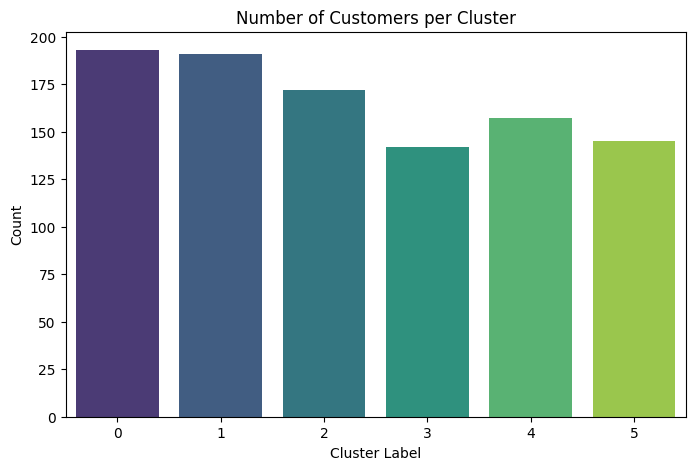

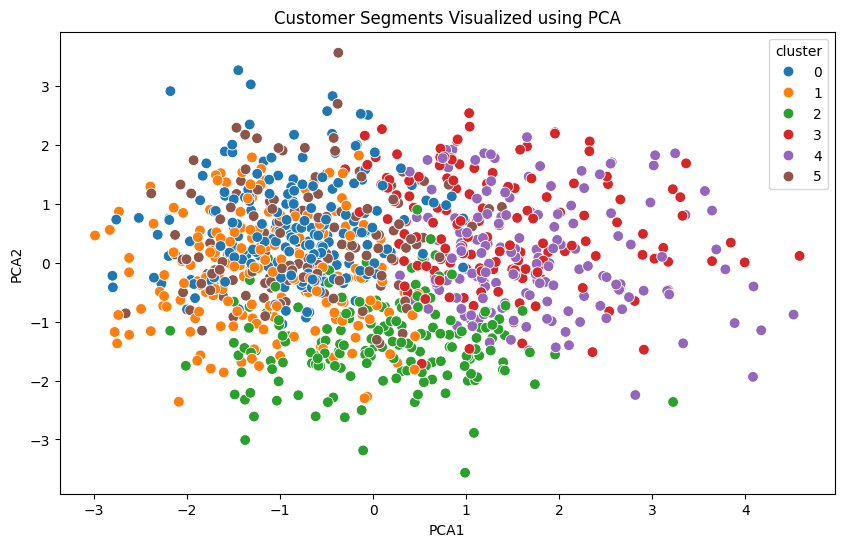

,Age,TotalSpend,TotalVisits,TimeOnSite(min),TotalPurchases,CartAbandonRate,ReturnedItems,UsedCoupons,RatingsGiven,LastPurchaseDate,Gender,FavoriteCategory,SignupChannel
cluster,,,,,,,,,,,,,
0,0.19,-0.54,-0.29,-0.16,-0.52,-0.39,-0.39,0.93,-0.19,0.12,0.78,0.67,-1.08
1,-0.40,-0.70,-0.38,-0.27,-0.73,-0.11,-0.40,-0.39,0.17,-0.22,-0.88,-0.85,-1.08
2,-0.25,0.11,-0.19,0.09,0.12,0.58,-0.05,-0.19,-0.02,-0.31,0.78,-1.35,1.27
3,-0.19,0.59,0.24,0.33,0.58,-0.30,1.39,-0.33,0.03,0.26,0.78,1.68,-1.08
4,0.51,1.32,-0.20,0.01,1.25,-0.21,0.19,0.07,0.07,-0.12,-0.88,-1.35,1.27
5,0.20,-0.49,1.10,0.13,-0.41,0.49,-0.46,-0.26,-0.05,0.38,-0.88,-0.85,1.27


In [ ]:
#Step 2: Cluster Assignments
# View few cluster labels
print(d_scaled['cluster'].value_counts().sort_index())

#Step 3: Analyze Cluster Sizes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=d_scaled,x='cluster',palette='viridis')
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()


# Step 4: Visualize Clusters (using PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
components=pca.fit_transform(X)
d_scaled['PCA1'],d_scaled['PCA2']= components[:,0],components[:,1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=d_scaled, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=60)
plt.title("Customer Segments Visualized using PCA")
plt.show()


#cluster profiling
# Aggregation with correct column names
cluster_summary = d_scaled.groupby('cluster').agg({
    'Age': 'mean',
    'TotalSpend': 'mean',
    'TotalVisits': 'mean',
    'TimeOnSite(min)': 'mean',
    'TotalPurchases': 'mean',
    'CartAbandonRate': 'mean',
    'ReturnedItems': 'mean',
    'UsedCoupons': 'mean',
    'RatingsGiven': 'mean',
    'LastPurchaseDate': 'mean',
    'Gender': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'FavoriteCategory': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'SignupChannel': lambda x: x.mode()[0] if not x.mode().empty else np.nan

}).round(2)


cluster_summary


interpretation
Cluster 0
Feature	Z-Score	Interpretation
Gender = 0.78	🔹 Male-dominant cluster
UsedCoupons = 0.09	✅ Slightly coupon-using
ReturnedItems = 0.02	⚠️ Slight return behavior
FavoriteCategory = -1.35	Likely a specific category (e.g., electronics)
SignupChannel = 1.27	Likely App users
Other metrics	~0	Average behavior overall

➡️ Interpretation:

💼 Male coupon users

App-first

Slight return risk

Normal purchases, average spend


Cluster 1
Feature	Z-Score	Interpretation
Gender = -0.88	👩 Female-dominant
TotalSpend = -0.09, TotalVisits = -0.02, TotalPurchases = -0.09	⬇️ Low activity overall
UsedCoupons = 0.08	Still uses coupons (a bit)
SignupChannel = -1.08	Possibly email or offline signup
RatingsGiven = 0.07	Slightly more likely to rate products

➡️ Interpretation:

🧍‍♀️ Low-spending female users

Low engagement, non-app channel

Not much value but not harmful

May respond to flash deals


 Cluster 2
Feature	Z-Score	Interpretation
Age = 0.11, TimeOnSite = 0.09	👴 Slightly older and decisive
UsedCoupons = -0.13	🚫 Doesn’t use coupons
CartAbandonRate = -0.13	✅ Almost no abandon behavior
SignupChannel = -1.08	Possibly old web/email channel
Gender = 0.78	👨 Male users
FavoriteCategory = 1.68	One specific category they like deeply (e.g., luxury/home)

➡️ Interpretation:

👴 Mature high-intent males

Loyal, decisive, no coupon need

Deserve premium targeting

Cluster 3
Feature	Z-Score	Interpretation
ReturnedItems = 0.10, CartAbandonRate = 0.10	❌ High return and abandon rate
Gender = 0.78	👨 Male users
FavoriteCategory = -1.35	Category skewed (electronics?)
Other features	Near-zero → average activity

➡️ Interpretation:

❌ High-risk returners

Abandon carts often

Might be sizing/quality issues

Educate or restrict return policies



Cluster 4
Feature	Z-Score	Interpretation
Gender = -0.88	👩 Female-heavy cluster
TotalPurchases = 0.07	🛍️ High purchase count
SignupChannel = 1.27	📱 App users
RatingsGiven = -0.15	😶 Low feedback / rating behavior

➡️ Interpretation:

📱 Loyal silent women

Buy often via app

Don’t rate products (no reviews)

Might respond to referral or review prompts



Cluster 5
Feature	Z-Score	Interpretation
Everything ≈ 0	Balanced in all dimensions
Gender = -0.88	Mostly female
SignupChannel = 1.27	App-based
FavoriteCategory = -0.85	Some shared category preference

➡️ Interpretation:

🔄 Balanced reliable users

App-driven

Not too high/low in anything

Safe for seasonal promotions or upsells



Final Cluster Mapping (Business View)
Cluster	Segment Name	Highlights	Risk	Strategy
0	       Male Coupon Users	Avg spenders, return a bit more, app-heavy	Return risk	App bundles with low return rates
1	🧍‍♀️ Low Value Females	Least loyal, spend less, non-app users	Low engagement	Budget alerts, entry deals
2	👴 Mature Decisive Buyers	Older males, loyal, no coupon use	None	Premium bundles, loyalty plans
3	❌ Indecisive Returners	Return and abandon prone	High cost	Educate + limit returns
4	📱 Loyal Silent Women	Frequent buyers, few reviews, app-heavy	No reviews	Prompt for ratings & referrals
5	🟤 Steady App Users	Balanced behavior, mostly female	None	Test upsells & seasonal promos



anomaly
Normal     980
Anomaly     20
Name: count, dtype: int64


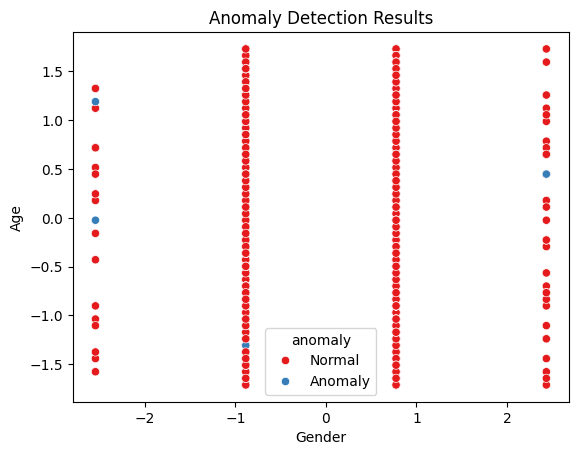

In [ ]:
#anamoly detection using isolation forest

from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
d_scaled['anomaly'] = iso.fit_predict(X)

# -1 means anomaly, 1 means normal
d_scaled['anomaly'] = d_scaled['anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# See how many anomalies detected
print(d_scaled['anomaly'].value_counts())

# Optional: Visualize anomalies
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=d_scaled['anomaly'], palette='Set1')
plt.title("Anomaly Detection Results")
plt.show()


In [ ]:
#recommendation system

# Map cluster-level strategies
def get_recommendation(cluster):
    mapping = {
        0: "App bundles with coupons",
        1: "Email offers + basic discounts",
        2: "Premium loyalty packs",
        3: "Only reviewed items + live support",
        4: "Review prompts + friend referrals",
        5: "New arrivals, seasonal campaigns"
    }
    return mapping.get(cluster, "Default recommendations")

d_scaled['Recommendation'] = d_scaled['cluster'].apply(get_recommendation)


In [ ]:
# 🔁 Input one customer (replace values)
new_customer = pd.DataFrame([{
    'Gender': 'male',
    'Age': 29,
    'Location': 'urban',
    'SignupChannel': 'app' ,
    'TotalVisits': 20,
    'TimeOnSite(min)': 45,
    'AvgSessionLength(min)':20,
    'TotalPurchases': 8,
    'TotalSpend': 9500,
     'FavoriteCategory': 'Electronics',
    'ReturnedItems': 1,
    'CartAbandonRate': 0.05,
    'UsedCoupons': 3,
    'RatingsGiven': 4,
    'LastPurchaseDate': 15,
       # ✅ Use exact string as in training
        # ✅ Same spelling as training
        # ✅ Match your training data
}])


#prediction pipeline
def predict_customer_segment_labelencoded(raw_data):
    raw = raw_data.copy()

    # Apply the SAME encoders used during training
    raw['Gender'] = enc_gender.transform(raw['Gender'])
    raw['FavoriteCategory'] = enc_category.transform(raw['FavoriteCategory'])
    raw['SignupChannel'] = enc_signup.transform(raw['SignupChannel'])
    raw['Location'] = enc_location.transform(raw['Location'])  # if used

    # Scale using trained scaler
    scaled = pd.DataFrame(scaler.transform(raw), columns=scaler.feature_names_in_)

    # Predict cluster and anomaly
    cluster = kmeans.predict(scaled)[0]
    strategy = get_recommendation(cluster)
    anomaly_flag = iso.predict(scaled)[0]
    anomaly = 'Anomaly' if anomaly_flag == -1 else 'Normal'

    return {
        'Cluster': cluster,
        'Recommendation': strategy,
        'Anomaly Status': anomaly
    }




# ⚡ Run it
result = predict_customer_segment_labelencoded(new_customer)
print(result)


{'Cluster': np.int32(4), 'Recommendation': 'Review prompts + friend referrals', 'Anomaly Status': 'Normal'}


In [ ]:
d_scaled.columns

Index(['Age', 'TotalVisits', 'TimeOnSite(min)', 'AvgSessionLength(min)',
       'TotalPurchases', 'TotalSpend', 'ReturnedItems', 'CartAbandonRate',
       'UsedCoupons', 'RatingsGiven', 'LastPurchaseDate', 'Gender_Missing',
       'Gender_female', 'Gender_male', 'Gender_other', 'Location_rural',
       'Location_sub-urban', 'Location_urban', 'SignupChannel_app',
       'SignupChannel_email', 'SignupChannel_referral', 'SignupChannel_web',
       'FavoriteCategory_Beauty', 'FavoriteCategory_Books',
       'FavoriteCategory_Clothing', 'FavoriteCategory_Electronics',
       'FavoriteCategory_Home', 'FavoriteCategory_Missing',
       'FavoriteCategory_Sports', 'Gender', 'Location', 'SignupChannel',
       'FavoriteCategory', 'CustomerID', 'cluster', 'PCA1', 'PCA2'],
      dtype='object')